In [1]:
#packages
import pandas as pd
import numpy as np
import warnings
import sqlite3

from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from xgboost import XGBRFRegressor

In [2]:
# hide warnings
warnings.filterwarnings('ignore')

In [3]:
def prepare_data():
    df = read_data()
    #df = format_columns(df)
    
    df['on_scene_dttm'] = pd.to_datetime(df['on_scene_dttm'])
    df['response_dttm'] = pd.to_datetime(df['response_dttm'])
    df['arrival_time'] = (df['on_scene_dttm'] - df['response_dttm'])
    df['minutes'] = (df.arrival_time.dt.seconds) / 60
    df['seconds'] = (df.arrival_time.dt.seconds)
    
    df_ag = df.groupby(["zone_idx"], as_index=False).agg({"accessibility_score":"mean", "minutes":"mean"})
    print(df_ag.head())
    
    return df_ag

In [4]:
def read_data():
    con = sqlite3.connect("fire_data_v4.db")
    cur = con.cursor()

    df = pd.read_sql("select calls_for_service.call_number " \
        ", calls_for_service.incident_number " \
        ", floating_catchment_output.[index] " \
        ", floating_catchment_output.zone_idx " \
        ", floating_catchment_output.accessibility_score " \
        ", floating_catchment_output.scenario_name " \
        ", calls_for_service.on_scene_dttm " \
        ", calls_for_service.response_dttm   " \
        ", category_mappings.[index] as primary_situation_index " \
        "from floating_catchment_output " \
        "inner join zone_idx_to_incident on  " \
        "zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx " \
        "inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number " \
        "left join fire_incidents AS fi on calls_for_service.incident_number = fi.incident_number " \
        "left join category_mappings on fi.primary_situation = category_mappings.primary_situation " \
        "where calls_for_service.unit_type in ('TRUCK', 'ENGINE') " \
        "and scenario_name = 'baseline'",con = con) 
    
    return df

In [5]:
def format_columns(df):
    df['alarm_format'] = pd.to_datetime(df['alarm_dttm'])
    df['arrival_format'] = pd.to_datetime(df['arrival_dttm'])
    df['arrival_time'] = (df['arrival_format'] - df['alarm_format'])
    df['minutes'] = (df.arrival_time.dt.seconds) / 60
    df['seconds'] = (df.arrival_time.dt.seconds)
    df['day_of_week'] = df['alarm_format'].dt.dayofweek
    df['dayflag'] = (df.alarm_format.dt.hour > 5) & (df.alarm_format.dt.hour < 18)
    
    point = df['case_location'].str.split(' ', n = 2, expand = True)
    point_x = point[1].str.split('(', n = 1, expand = True)
    point_y = point[2].str.split(')', n = 1, expand = True)
    
    df['point_x'] = point_x[1]
    df['point_y'] = point_y[0]
    
    return df

In [6]:
df = prepare_data()
df.head()

   zone_idx  accessibility_score   minutes
0         8             0.000803  5.254762
1         9             0.001147  4.466082
2        10             0.000968  4.545000
3        11             0.000501  3.450722
4        12             0.000501  4.271189


,zone_idx,accessibility_score,minutes
0,8,0.000803,5.254762
1,9,0.001147,4.466082
2,10,0.000968,4.545000
3,11,0.000501,3.450722
4,12,0.000501,4.271189


In [7]:
class ModelData:
    x = None
    y = None
    x_train = None
    x_test = None
    y_train = None
    y_test = None
    scaled_x_train = None
    scaled_x_test = None

    model = None
    target_to_predict = None
    predictors = None
    XGB = None
    gscv_XGB = None

In [8]:
def configure_sets(md):
    md.predictors = ['zone_idx', 'accessibility_score']
    md.target_to_predict = 'minutes'
    
    md.x = df[md.predictors].values
    md.y = df[md.target_to_predict].values

    #Split the data into training and testing set
    md.x_train, md.x_test, md.y_train, md.y_test = train_test_split(md.x, md.y, test_size = 0.30, random_state = 614)

In [9]:
def data_normalization(md):
    scaler = StandardScaler()
    md.scaled_x_train = scaler.fit_transform(md.x_train)
    md.scaled_x_test = scaler.transform(md.x_test)

In [10]:
def create_model(md):
    #data_normalization(md)
    
    md.model = XGBRFRegressor(n_estimators = 1000, subsample = 0.9, colsample_bynode = 0.2)

    #Printing all the parameters of XGBoost
    print(md.model)

In [11]:
def tune_hyper_parameters(md):
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators': [800, 1000, 1200],
        'objective': ['reg:squarederror']
    }

    md.gscv_XGB = GridSearchCV(estimator = md.model, param_grid = param_grid)
    md.gscv_XGB.fit(md.scaled_x_train, md.y_train)
    
    print(md.gscv_XGB.best_params_)
    
    #'n_estimators': [100, 1000, 2000] - Run results:
    #{'n_estimators': 1000}

In [12]:
def fit_data(md):
    #Creating the model on Training Data
    md.XGB = md.model.fit(md.scaled_x_train, md.y_train)
    
    prediction = md.XGB.predict(md.scaled_x_test)

    #Measuring Goodness of fit in Training data
    print('R2 Value:', metrics.r2_score(md.y_train, md.XGB.predict(md.scaled_x_train)))

    #Plotting the feature importance for Top 10 most important columns 
    %matplotlib inline
    feature_importances = pd.Series(md.XGB.feature_importances_, index = md.predictors)
    feature_importances.nlargest(10).plot(kind = 'barh')

In [13]:
def predict_using_training_set(md):
    prediction = md.XGB.predict(md.scaled_x_test)
    
    training_set_predictions = pd.DataFrame(data = md.scaled_x_test, columns = md.predictors)
    training_set_predictions[md.target_to_predict] = md.y_test
    training_set_predictions[('Predicted' + md.target_to_predict)] = prediction
    training_set_predictions.head()
    
    print(training_set_predictions.head(15))
    print(training_set_predictions.tail(15))

In [14]:
def get_accuracy(md):
    y_predict_train = md.XGB.predict(md.scaled_x_train)
    y_predict_test = md.XGB.predict(md.scaled_x_test)
    
    print("Accuracy: " + str(md.XGB.score(md.scaled_x_train, md.y_train)))
    print("Mean CV Score: " + str(cross_val_score(md.XGB, md.scaled_x_train, md.y_train,cv = 10).mean()))

In [15]:
model_data = ModelData()

configure_sets(model_data)
data_normalization(model_data)

In [16]:
create_model(model_data)
tune_hyper_parameters(model_data)

XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=0.2, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=None,
               missing=nan, monotone_constraints=None, n_estimators=1000,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, subsample=0.9,
               tree_method=None, validate_parameters=None, verbosity=None)
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 800, 'objective': 'reg:squarederror', 'subsample': 0.7}


R2 Value: 0.7714886724687866


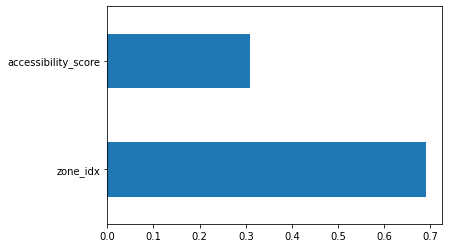

In [17]:
fit_data(model_data)

In [18]:
predict_using_training_set(model_data)
get_accuracy(model_data)

    zone_idx  accessibility_score    minutes  Predictedminutes
0   0.747430             0.227362   5.498942          3.634107
1   1.019515            -0.268159   2.615835          3.566792
2   1.835771            -1.195879   9.792130          3.633782
3   1.270671            -0.150632   2.861669          3.701924
4   1.124163            -1.195879   3.372279          3.162816
5  -0.016502            -0.564132   3.325945          3.538997
6   0.674176            -0.654966   2.846033          3.557937
7  -0.131615             0.868940   4.569103          3.493571
8   0.935797            -0.364909   4.355014          3.781291
9  -1.230422             0.778230   4.600667          3.351596
10  1.155558             0.330127   4.085543          3.637087
11 -0.121150            -1.233585   3.440021          3.171054
12  0.611387            -0.882057   2.622527          3.238580
13 -1.418789             0.239438   4.189662          3.485406
14 -1.345535            -0.829854  11.038889          5